# Test Overlap between sources in a blend

In [1]:
# Import Packages and setup
from __future__ import print_function, division
import os
from collections import OrderedDict
import logging

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# Make the plots look pretty
matplotlib.rc('font',size=13)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')
# Use the same color cylcer as Seaborn
from cycler import cycler
color_cycle = [u'#4c72b0', u'#55a868', u'#c44e52', u'#8172b2', u'#ccb974', u'#64b5cd']
matplotlib.rcParams['axes.prop_cycle'] = cycler("color", color_cycle)

import lsst.afw.table as afwTable
from lsst.utils import getPackageDir
import lsst.log as log
import lsst.meas.deblender
from lsst.meas.deblender import proximal, display, sim, baseline
import lsst.meas.deblender.utils as debUtils

logger = logging.getLogger("lsst.meas.deblender")
logger.setLevel(logging.INFO)
log.setLevel("", log.INFO)
plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)
dlogger = logging.getLogger("deblender")
dlogger.setLevel(logging.INFO)

In [2]:
# Load the data
dataPath = os.path.abspath(os.path.join(lsst.utils.getPackageDir("testdata_deblender"), 'sim_data'))
filters = ["u", "g", "r", "i", "z", 'y']
imgFilename = os.path.join(dataPath, "test1/{0}_{1}.fits")
catFilename = os.path.join(dataPath, "test1/det_merge.fits")
simFilename = os.path.join(dataPath, "test1/catalog_true.fits")

expDb = proximal.ExposureDeblend(filters, imgFilename, catFilename, simFilename, useExactPeaks=True)
#pidx = 3
#condition = (expDb.mergedTable["peaks"]<=10) & (expDb.mergedTable["peaks"]>1)
pidx = 6
condition = None#(expDb.mergedTable["peaks"]<=5) & (expDb.mergedTable["peaks"]>1)
footprint, peaks = expDb.getParentFootprint(parentIdx=pidx, condition=condition, display=False)
deblend = proximal.DeblendedParent(expDb, footprint, peaks)

INFO:lsst.meas.deblender.proximal:Total parents: 9
INFO:lsst.meas.deblender.proximal:Unblended sources: 4
INFO:lsst.meas.deblender.proximal:Sources with multiple peaks: 5


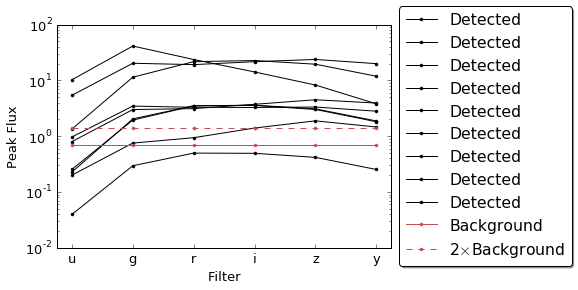

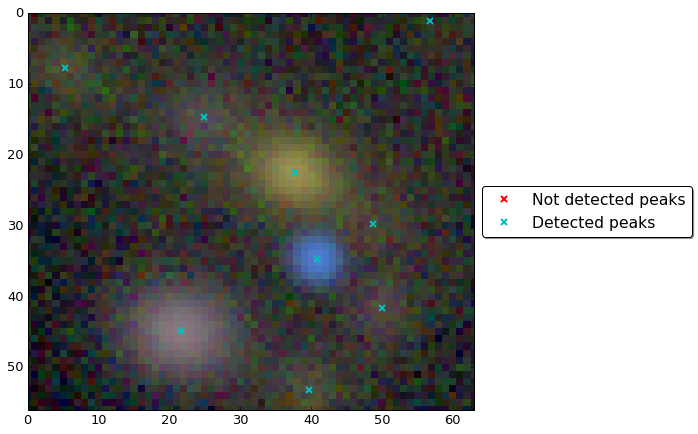

In [3]:
# Build a table of peaks detected by the pipeline
peakTable = sim.buildFootprintPeakTable(footprint, filters, peaks=peaks)
# Estimate the noise in the image
avgNoise = sim.getNoise(expDb.calexps)
simTable,idx, unmatchedTable = sim.matchFootprintToRef(footprint, peakTable, expDb.simTable,
                                                        filters,avgNoise=avgNoise, expDb=expDb,)
# Calculate the flux for isolated (non-blended) sources
sim.calculateIsolatedFlux(filters, expDb, peakTable, simTable, avgNoise)

In [4]:
peakCoords = np.array([simTable["x"],simTable["y"]]).T
admm = expDb.deblendParent(
    condition=condition,
    parentIdx=pidx,
    display=False,
    maxiter=300,
    #min_iter=20,
    #strict_constraints="M",
    constraints="M",
    usePsf=False,
    psfThresh=3e-3,
    e_rel=1e-2,
    monotonicUseNearest=True,
    l0_thresh=.35,
    algorithm="ADMM",
)

/Users/fred/projects/proxmin/proxmin/proximal.py:60: RuntimeWarning: invalid value encountered in true_divide
  return X / np.sum(X, axis=axis, keepdims=True)
INFO:proxmin.algorithms:0: convergence: [False, False], iterations: [   1.  299.]
INFO:proxmin.algorithms:1: convergence: [False, False], iterations: [   1.  236.]
INFO:proxmin.algorithms:2: convergence: [False, False], iterations: [   0.  136.]
INFO:proxmin.algorithms:3: convergence: [False, False], iterations: [   0.  167.]
INFO:proxmin.algorithms:4: convergence: [False, False], iterations: [   0.  139.]
INFO:proxmin.algorithms:5: convergence: [False, False], iterations: [   0.  125.]
INFO:proxmin.algorithms:6: convergence: [False, False], iterations: [   0.  150.]
INFO:proxmin.algorithms:7: convergence: [False, False], iterations: [   0.  164.]
INFO:proxmin.algorithms:8: convergence: [False, False], iterations: [   0.  149.]
INFO:proxmin.algorithms:9: convergence: [False, False], iterations: [   0.  138.]
INFO:proxmin.algorith

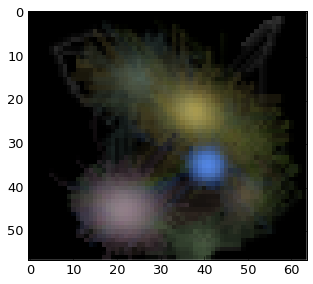

In [5]:
display.plotColorImage(admm.model);

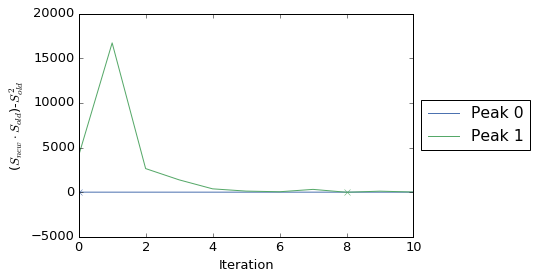

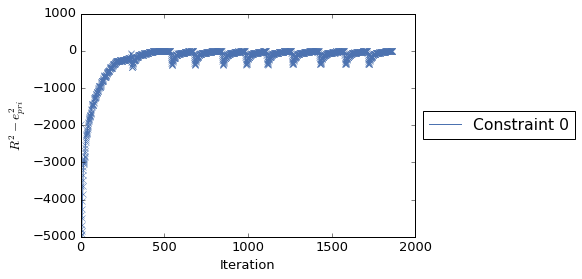

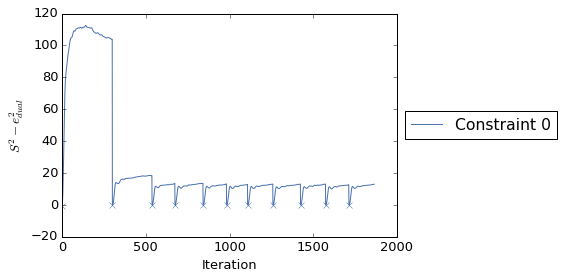

In [6]:
admm.convergencePlots()

In [7]:
sdmm = expDb.deblendParent(
    condition=condition,
    parentIdx=pidx,
    display=False,
    maxiter=300,
    #min_iter=20,
    #strict_constraints="M",
    constraints="MS",
    usePsf=False,
    psfThresh=3e-3,
    e_rel=1e-2,
    monotonicUseNearest=True,
    l0_thresh=.35,
    algorithm="SDMM",
)

/Users/fred/projects/proxmin/proxmin/proximal.py:60: RuntimeWarning: invalid value encountered in true_divide
  return X / np.sum(X, axis=axis, keepdims=True)
INFO:proxmin.algorithms:0: convergence: [False, False], iterations: [   1.  299.]
INFO:proxmin.algorithms:1: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:2: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:3: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:4: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:5: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:6: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:7: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:8: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorithms:9: convergence: [False, False], iterations: [   0.  299.]
INFO:proxmin.algorith

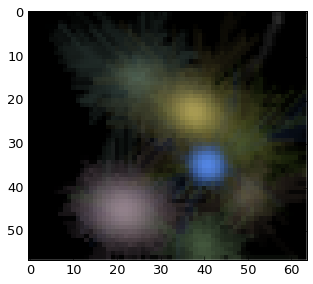

In [9]:
display.plotColorImage(sdmm.model);

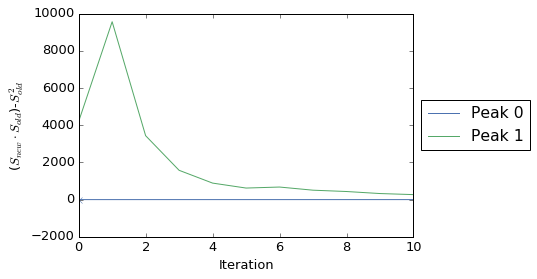

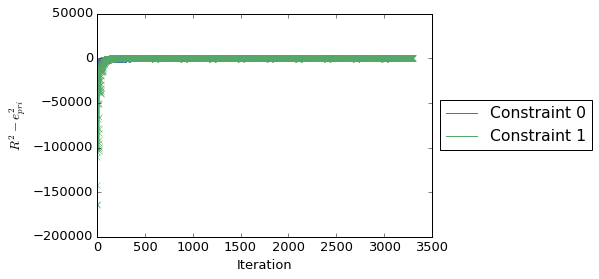

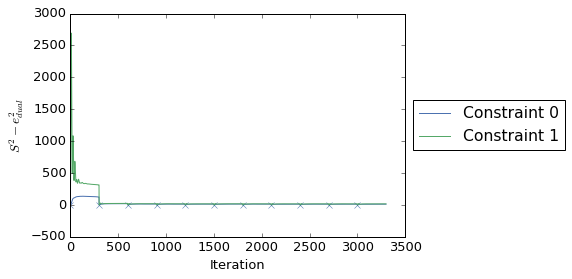

In [10]:
sdmm.convergencePlots()

In [12]:
glmm = expDb.deblendParent(
    condition=condition,
    parentIdx=pidx,
    display=False,
    maxiter=300,
    #min_iter=20,
    strict_constraints="M",
    constraints="S",
    usePsf=False,
    psfThresh=3e-3,
    e_rel=1e-2,
    monotonicUseNearest=True,
    l0_thresh=.35,
    algorithm="GLMM",
)

/Users/fred/projects/proxmin/proxmin/proximal.py:60: RuntimeWarning: invalid value encountered in true_divide
  return X / np.sum(X, axis=axis, keepdims=True)
INFO:proxmin.algorithms:Completed 300 iterations
INFO:lsst.meas.deblender.proximal:Total Runtime: 3.74 s


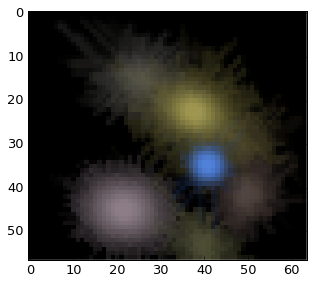

In [13]:
display.plotColorImage(glmm.model);

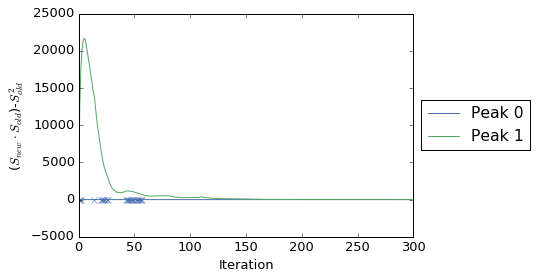

IndexError: index 2 is out of bounds for axis 2 with size 1

In [15]:
glmm.convergencePlots()